# CS 663 - Machine Learning Spring, 2024
## Assignment 02 - KMeans

### Goals:
1. Develop your version of K-Means.
2. Compare performance of different implementations.
3. Demonstrate understanding of clustering algorithms like K-Means, DBSCAN, and Hierarchical.
4. Extend functionality of K-Means implementation through additional parameters.



## Problem 3 : Choose and run clustering algorithms

#### Problem:
Clustering analysis on Chicago data subsets.

#### Datasets:
1. Chicago taxi data (location coordinates).

#### Algorithms:
- K-means

## Evaluation:
- Output showcasing clusters.
- Evaluation metrics: Silhouette score for Chicago taxi data; Inertia


## Approach

1. We first import the dataset and perform EDA
2. Based on EDA we draw conclusions on nature of the dataset and the expected clustering algorithm that can be used.
3. Clean the data and do hyperparameter tuning on them.
4. Disply the cluster
5. Get metrics on the model output and draw necessary conslusions

## References

- [Scikit-Learn Documentation: KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)  
  Official documentation for the KMeans clustering algorithm in Scikit-Learn.

- [IEEE Xplore Article: SKLearn reference values](https://ieeexplore.ieee.org/document/9260048)  


# Problem 3A:

**Dataset:** Chicago taxi data, an approximately week-long subset of the full dataset

**Problem Statement:** 
Let's work on a problem statement to identify the best performing and profitable taxis in Chicago. We will resort to the clustering method wherein the averages of features indicating high performance should be categorized into one cluster and so on. The number of clusters would be decided based on stability and the segregation we want.


In [1]:
import sys
sys.path.append("./modules")
from blob_data._blob_data import generate_blob_data
from eda.eda import EDAAnalyzer
from kmeans._kmeans import KMeans as myKMeans
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from cluster_algo.kmeans.kmeans_clustering import KMeansClustering

#### EDA

In [2]:
df = pd.read_csv(r"./input/Taxi_Trips__2013-2023_.csv")
df.columns

Index(['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp',
       'Trip Seconds', 'Trip Miles', 'Pickup Census Tract',
       'Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Pickup Centroid Location',
       'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',
       'Dropoff Centroid  Location'],
      dtype='object')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101788 entries, 0 to 101787
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Trip ID                     101788 non-null  object 
 1   Taxi ID                     101779 non-null  object 
 2   Trip Start Timestamp        101788 non-null  object 
 3   Trip End Timestamp          101788 non-null  object 
 4   Trip Seconds                101763 non-null  float64
 5   Trip Miles                  101788 non-null  float64
 6   Pickup Census Tract         35179 non-null   float64
 7   Dropoff Census Tract        35054 non-null   float64
 8   Pickup Community Area       95650 non-null   float64
 9   Dropoff Community Area      92192 non-null   float64
 10  Fare                        101681 non-null  float64
 11  Tips                        101681 non-null  float64
 12  Tolls                       101681 non-null  float64
 13  Extras        

In [4]:
df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'])
print("From:", df['Trip Start Timestamp'].min())
print("To:", df['Trip Start Timestamp'].max())

From: 2023-02-01 00:15:00
To: 2023-12-13 15:00:00


/var/folders/gn/t2nnttv94bddcfhfcjtwnz0r0000gn/T/ipykernel_43454/140940277.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'])


In [5]:
# List of columns indicating profitable and good performing taxis
features = ['Trip Seconds', 'Trip Miles', 'Fare', 'Tips','Tolls','Extras','Trip Total']

In [6]:
profitable_df = df[features+['Taxi ID','Trip ID']]
eda_analyzer = EDAAnalyzer(profitable_df)
eda_analyzer.display_head(10)

,Trip Seconds,Trip Miles,Fare,Tips,Tolls,Extras,Trip Total,Taxi ID,Trip ID
0,1140.0,11.20,28.75,0.00,0.0,21.0,49.75,275f3f891b8c0ba8f2958873f850d2a03993c99f5f79f6...,52dc9029821e61db30a51838cb3cd711bd0e03cb
1,660.0,2.70,10.75,2.25,0.0,0.0,13.00,6c87f1d023a9d7146ae81b6aa4648bf98cec52cceb9f08...,11eeb6710caa0606028c7ba025bfa18c277886e8
2,480.0,0.00,7.75,2.00,0.0,0.0,9.75,bb4e75d3065311c33024a434640731c43fd2cf9e4482eb...,113aa7bf346c585bb941cda2d5c0015c8a1472f0
3,1620.0,0.00,47.75,15.25,0.0,28.0,91.00,57c40509cae37a0e5e536a657cdb7f8c6824314bc466a7...,2503e3944e5c82b89638447ad361638111129375
4,360.0,0.10,9.75,0.00,0.0,4.0,13.75,40720025b84fa778c47d6637db01b1d8f2de2eabafa529...,23ddcfba2ad714fe0303909961ea74873be50da2
5,819.0,6.57,17.58,4.10,0.0,0.0,21.68,c4a594a1f522860a7f91aca9a3cccbef723a1178f1fde9...,3f83825d29cc2da85a9802dac2bbad8126552c8c
6,1360.0,7.86,22.75,0.00,0.0,0.0,22.75,137d4f780c3823fdc5f26cec160a8c9f8eb952f769c5bc...,3f40bb12ed01040ff4f5b7e7ae7ad237cda0a919
7,1320.0,19.10,46.00,13.10,0.0,6.0,65.10,9a423881d4046f5590943c08ec5e58d59f5ebd91fe26aa...,3a9b88194316fcfe4b2c9c2d472769af11c324ce
8,1320.0,0.00,36.75,10.30,0.0,4.0,51.05,53c712575d7763eef95e1bd0c056f1d6c55b65bc3a2161...,465225affd3e44ca7596fc832b9e4168f01d6356
9,659.0,4.85,14.75,2.29,0.0,0.0,17.54,c57508f365f1bdac3be5e7de12fb19c8d669c37d515e41...,465442ec96e0b741b5fb1fe47c332b59ae9a997c


In [7]:
eda_analyzer.display_shape()

'Shape of data: rows: 101788 cols: 9'

In [8]:
eda_analyzer.display_column_info()

,Column Name,Non-null Count,Percent Non-null,Data Type
0,Trip Miles,101788,100.000000,float64
1,Trip ID,101788,100.000000,object
2,Taxi ID,101779,99.991158,object
3,Trip Seconds,101763,99.975439,float64
4,Fare,101681,99.894880,float64
5,Tips,101681,99.894880,float64
6,Tolls,101681,99.894880,float64
7,Extras,101681,99.894880,float64
8,Trip Total,101681,99.894880,float64


In [9]:
eda_analyzer.describe()

,count,mean,std,min,25%,50%,75%,max
Trip Seconds,101763.0,1102.644891,1831.031101,0.0,420.00,836.0,1516.0,86003.0
Trip Miles,101788.0,6.021135,7.572349,0.0,0.87,2.6,10.8,814.3
Fare,101681.0,20.466054,18.103452,0.0,7.75,13.5,31.0,999.0
Tips,101681.0,2.452347,3.918353,0.0,0.00,0.0,3.0,250.0
Tolls,101681.0,0.014503,0.602782,0.0,0.00,0.0,0.0,78.0
Extras,101681.0,1.679117,5.208910,0.0,0.00,0.0,1.0,182.0
Trip Total,101681.0,24.739358,22.641634,0.0,9.50,16.0,33.9,999.0


### Univariate Analysis

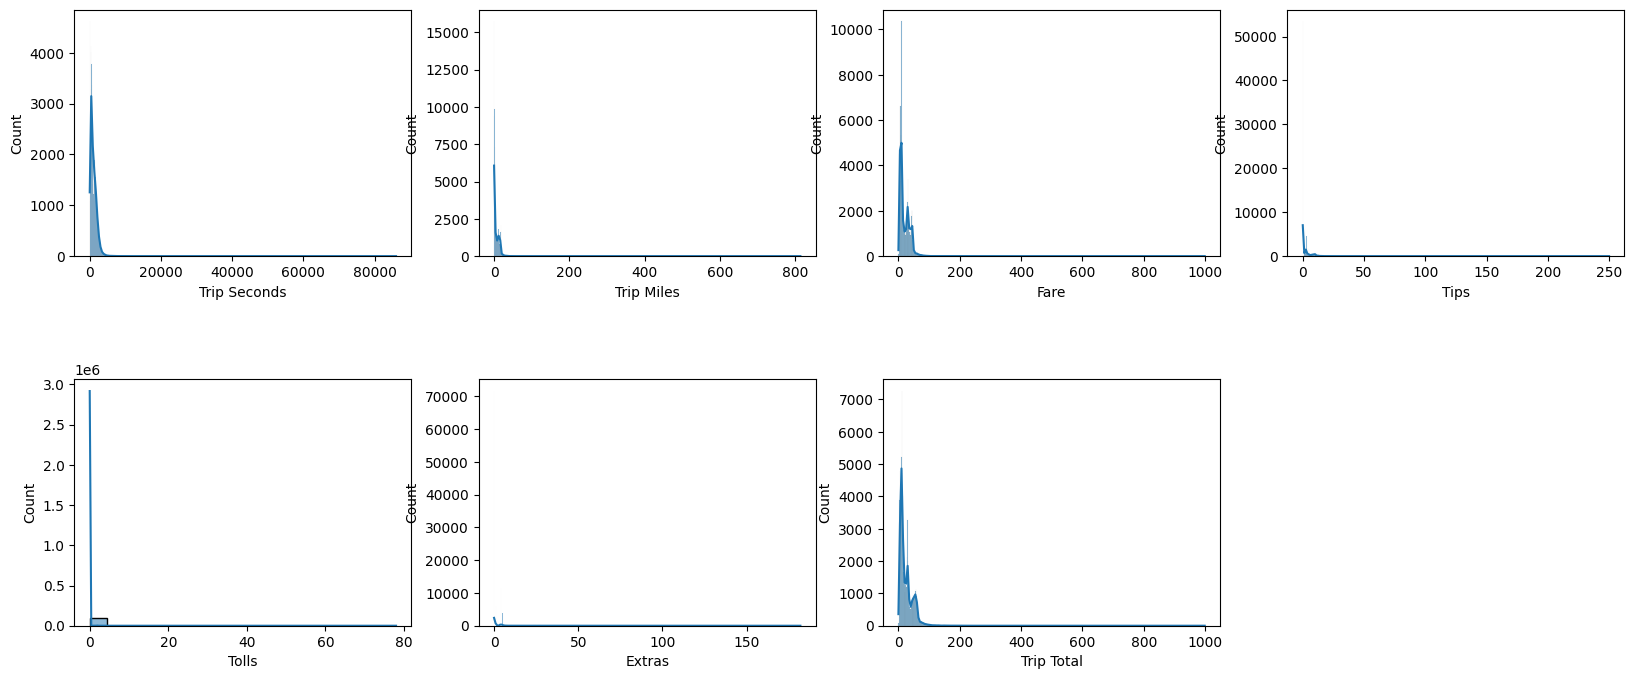

In [10]:
eda_analyzer.plot_histograms(ignore_columns=["Taxi ID","Trip ID"])

#### Bivariate Analysis

<Axes: xlabel='Pickup Centroid Longitude', ylabel='Pickup Centroid Latitude'>

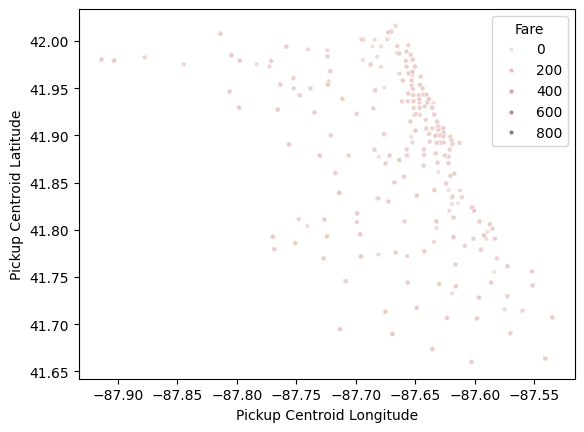

In [11]:
sns.scatterplot(data=df, x=df["Pickup Centroid Longitude"], y=df["Pickup Centroid Latitude"],s=10,hue=df.Fare,alpha=0.7)

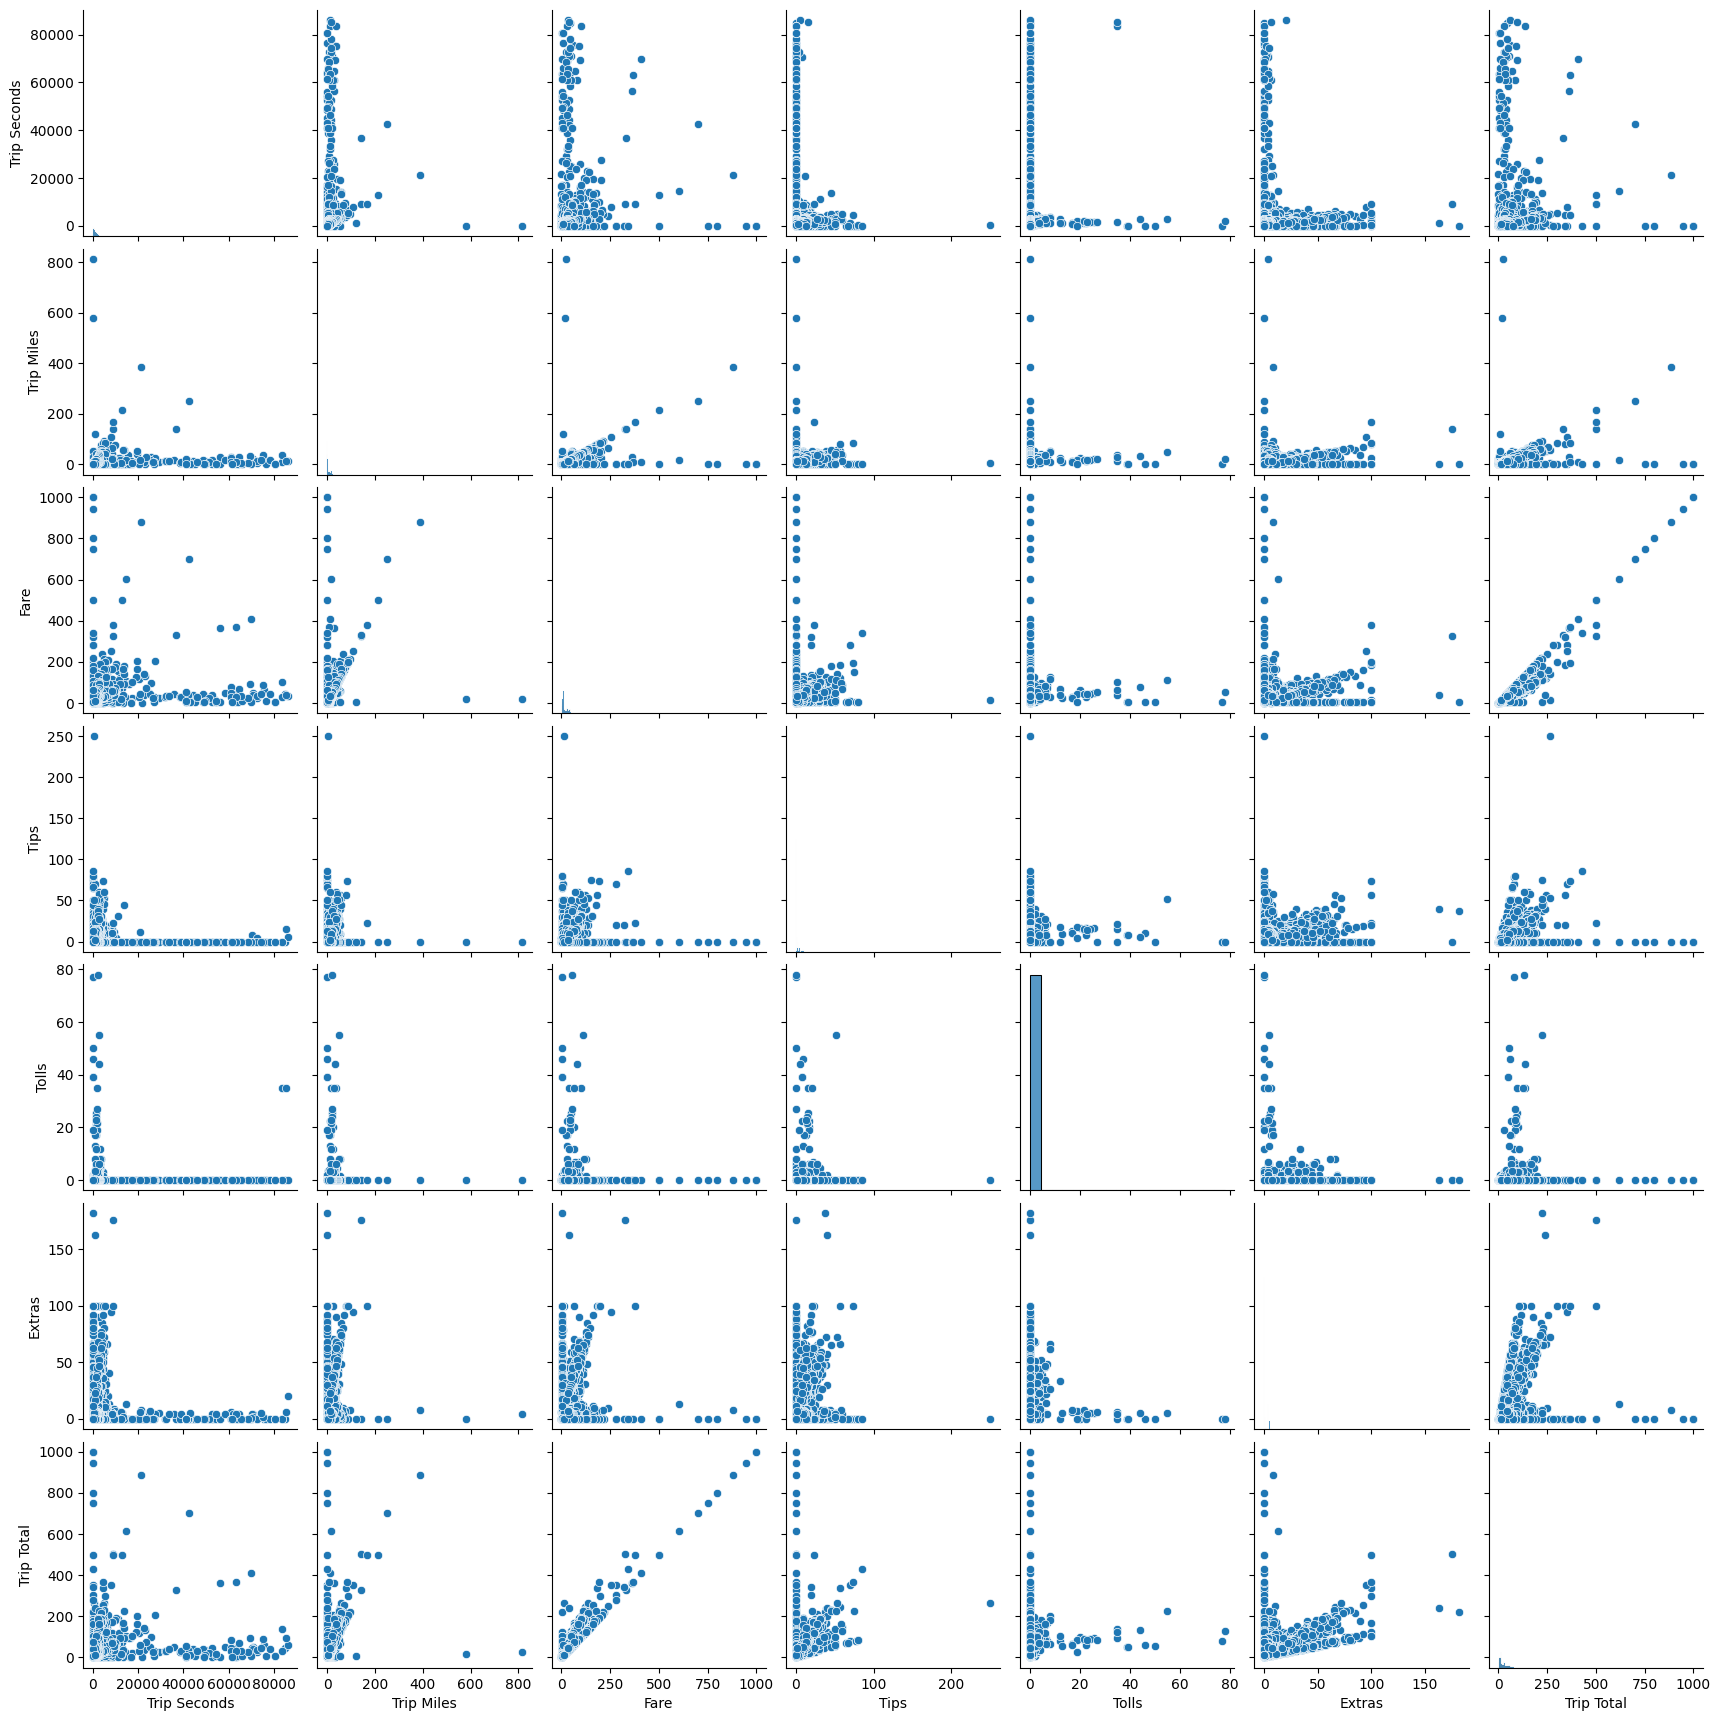

In [12]:
eda_analyzer.get_pair_plot()

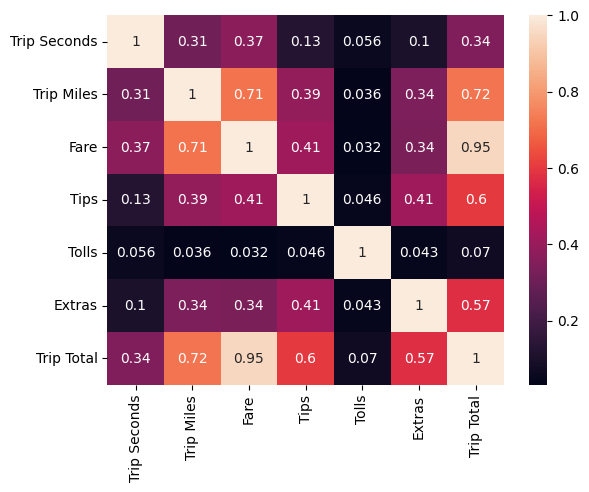

In [13]:
eda_analyzer.get_heat_map()

In [14]:
eda_analyzer.get_top_correlated_pairs()

,Column 1,Column 2,Correlation Coefficient,Correlation Category
14,Fare,Trip Total,0.950137,High
10,Trip Miles,Trip Total,0.718897,High
6,Trip Miles,Fare,0.713493,High
17,Tips,Trip Total,0.601497,Moderate
20,Extras,Trip Total,0.573082,Moderate
16,Tips,Extras,0.411605,Moderate
11,Fare,Tips,0.410178,Moderate
7,Trip Miles,Tips,0.388246,Moderate
1,Trip Seconds,Fare,0.371959,Moderate
5,Trip Seconds,Trip Total,0.344165,Moderate


### Data quality evaluvation : 
 * Chicago taxi data, an approximately week-long subset of the full dataset
 * Data is from 
    From: 2023-02-01 00:15:00
    To: 2023-12-13 15:00:00
 * Datamap looks like Chicago city  
 * There are a set of pickup and dropoff point
 * The data follows a left-skewed data

# Clustering Algorithm Recommendation:

Based on the characteristics of the dataset and problem statement, we are using the K-means clustering algorithm for the following reasons:

- **Scalability:** K-means is computationally efficient since the data could be expanded to cities and much big dates
- **Simple Implementation:** K-means is easy to understand and implement, facilitating quick exploration and analysis of the data.
- **Numeric Data:** K-means works well with numeric data
- **Cluster Centroids:** K-means assigns data points to clusters based on their proximity to cluster centroids, allowing for the identification of groups of taxis with similar performance metrics.


### Model Cleaning

 * The model data requires to fill na and normalization.
 * It would be done as a part of hyperparameter tuning and fit
 * 

In [27]:
features_v1 = ['Trip Seconds', 'Trip Miles', 'Pickup Census Tract',
       'Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude','Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',]
features_v2 = ['Pickup Census Tract',
       'Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area','Pickup Centroid Latitude',
       'Pickup Centroid Longitude','Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']
features = ['Pickup Centroid Latitude',
       'Pickup Centroid Longitude','Trip Seconds', 'Trip Miles', 'Tips','Tolls','Extras','Trip Total']

In [28]:
model_data = df[features]

### Model Training

In [29]:
kmeans_clustering = KMeansClustering()

 #### Hyperparameter tuning 

In [30]:
kmeans_clustering.fit_hyperparameter_tuning(model_data, sample_size=10000)

Number of clusters: 3, Silhouette Score: 0.5234163206585916
optimal number of clusters :  3


In [31]:
cluster_labels, cluster_centers = kmeans_clustering.fit(model_data)
df["Cluster_Labels"] = cluster_labels

#### Model Evaluvation

 * Mean of clusters
 * Model Output - Clusters
   

In [32]:
kmeans_clustering.get_feature_means(model_data)

,Pickup Centroid Latitude,Pickup Centroid Longitude,Trip Seconds,Trip Miles,Tips,Tolls,Extras,Trip Total
2,41.837288,-87.655772,1874.436291,11.412191,2.446372,0.001882,1.053167,37.439666
1,41.900169,-87.649287,629.996115,2.072860,1.192245,0.001372,0.265808,12.181689
0,41.973241,-87.891650,1915.908900,14.201618,7.330405,0.081828,7.963691,56.595932


<Axes: xlabel='Dropoff Community Area', ylabel='Trip Total'>

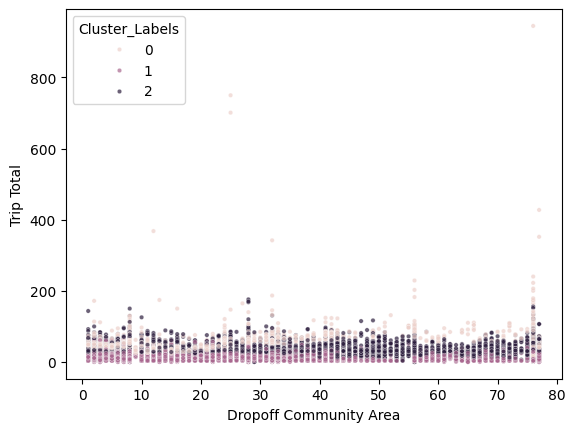

In [33]:
sns.scatterplot(data=df, x=df["Dropoff Community Area"], y=df["Trip Total"],s=10,hue=df.Cluster_Labels,alpha=0.7)

<Axes: xlabel='Trip Seconds', ylabel='Trip Total'>

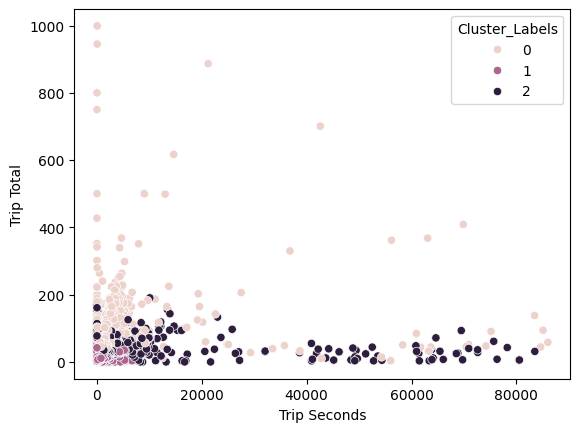

In [34]:
sns.scatterplot(data=df, x=df["Trip Seconds"], y=df["Trip Total"], hue=df.Cluster_Labels)

<Axes: xlabel='Dropoff Centroid Longitude', ylabel='Dropoff Centroid Latitude'>

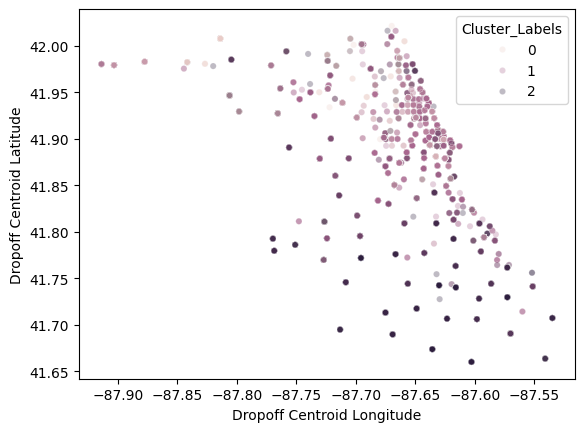

In [39]:
sns.scatterplot(data=df, x=df["Dropoff Centroid Longitude"], y=df["Dropoff Centroid Latitude"],s=20,hue=df.Cluster_Labels,alpha=0.3)

<Axes: xlabel='Pickup Community Area', ylabel='Dropoff Community Area'>

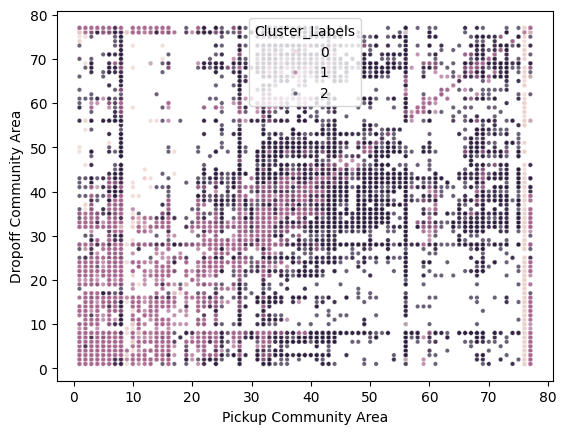

In [36]:
sns.scatterplot(data=df, x=df["Pickup Community Area"], y=df["Dropoff Community Area"],s=10,hue=df.Cluster_Labels,alpha=0.7)

<Axes: xlabel='Payment Type', ylabel='Tips'>

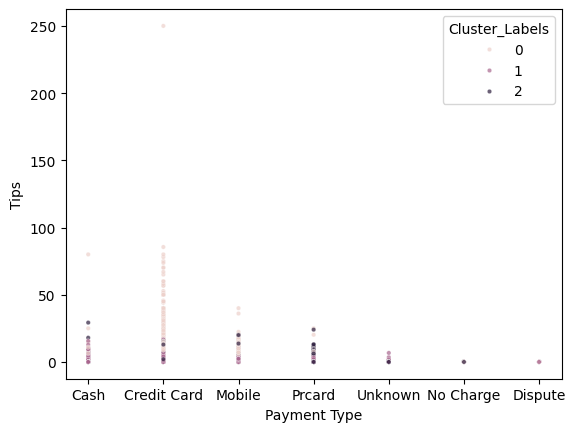

In [37]:
sns.scatterplot(data=df, x=df["Payment Type"], y=df["Tips"],s=10,hue=df.Cluster_Labels,alpha=0.7)

<Axes: xlabel='Pickup Community Area', ylabel='Trip Total'>

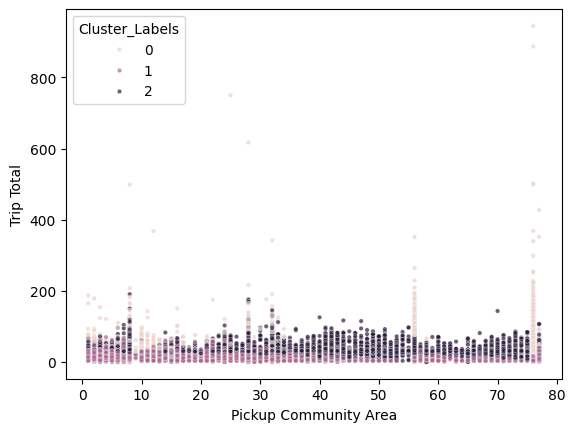

In [38]:
sns.scatterplot(data=df, x=df["Pickup Community Area"], y=df["Trip Total"],s=10,hue=df.Cluster_Labels,alpha=0.7)

In [42]:
kmeans_clustering.get_feature_means(model_data)

,Pickup Centroid Latitude,Pickup Centroid Longitude,Trip Seconds,Trip Miles,Tips,Tolls,Extras,Trip Total
2,41.837288,-87.655772,1874.436291,11.412191,2.446372,0.001882,1.053167,37.439666
1,41.900169,-87.649287,629.996115,2.072860,1.192245,0.001372,0.265808,12.181689
0,41.973241,-87.891650,1915.908900,14.201618,7.330405,0.081828,7.963691,56.595932


### Model and output evaluvation : 
    * The metrics you used to evaluate the output. What kind of performance did you get from that algorithm? Is that what you expected?

## Conclusions:

### Evaluation Metrics:
- Both numerical and visual metrics are used for evaluation.
  - For numerical evaluation, we consider the average of each feature in the cluster and the Silhouette Score.
  - For visual evaluation, scatter plots of different numerical features and geographical location markers are utilized.

### Analysis of Centroids:
- Clear differences are observed in feature centroids, indicating good segregation among clusters.
  - Trip charge ranges from 12 to 56 across the four clusters, suggesting distinct pricing patterns.

### Silhouette Score:
- The Silhouette Score of 0.52 is slightly lower than expected but represents borderline cases that require careful consideration.

### Insights from Visual Analysis:
- The scatter plots illustrate distinct clustering patterns, particularly in trip charge distribution.
- Mimicking the properties of cluster 1 (high fares and charges) could lead to higher profitability.
- Clusters are categorized into Power Clusters (PC, high profits), Mean Clusters (MC), and Weak Clusters (WC).
- Proximity to the city center correlates with higher profitability (PC).
- Counterintuitively, proximity to the drop-off location is associated with higher profitability, suggesting operating within a specific area increases profitability.

### Further Considerations:
- Future strategies could focus on optimizing operations to align with the characteristics of Power Clusters (PC).
- Understanding geographical and operational factors influencing profitability can guide strategic decision-making.
